# COGS 118A- Final Project

# Names

- Daniel Milton
- Isabella Gonzalez
- Dhruva Kolikineni
- Harini Adivikolanu
- Brandon Rocchio

# Abstract 
Classification involves predicting discrete class labels for unlabeled data given information on the data. The data we are working with is information from individuals' shopping trips at Walmart. The data is broken down into 7 observations, one of which is the trip type which tells us what type of shopping trip this customer was on, visit number which organizes the data into individual shopping trips, weekday that the trip was done on, UPC number of the item purchased, department of purchase and the fineline number which is a number that Walmart made helping us specify the items purchased. Given certain data such as what weekday it is, what department it was in, and what the UPC was, our goal is to be able to predict what type of shopping trip someone was on based off of a couple pieces of data.



# Background

Although supervised classification methods have been studied greatly throughout the years, research specific to this problem, on classifying a grocery trip based on the items bought remains low. There are multiple classification algorithms we can attempt in order to classify the 38 different types of shopping trips there are. K-nearest neighbors, decision trees, random forest classifiers, neural networks and logistic regression are commonly used in order to solve classification problems. Due to the low amount of research done in this specific problem area, this background section will be a small literature review of potential classification algorithms to use for our problem.

Firstly, K Nearest Neighbors works based on the idea that for a target variable, the k number of patterns nearest to that target variable can provide useful information in order to properly classify the target variable. KNN assigns the target variable the classification of the majority of the nearest neighbors<a name="first"></a>[<sup>[1]</sup>](#firstnote). The downfalls of KNN are that there is no right 'K' to choose and it can be computationally inefficient. Second, Decision Trees are another classification method we want to attempt, these are popular due to their good accuracy scores and their computational efficiency<a name="second"></a>[<sup>[2]</sup>](#secondnote). The random forest classifier works by using multiple tree classifiers where each classifier is generated by using a random vector and each tree vottes for the most 'popular' class to classify an input vector<a name="third"></a>[<sup>[3]</sup>](#thirdnote). This paper uses random forests to classify remote sensing which they concluded was just as accurate as using a support vector machine.

Neural Networks and logistic regression are other potential algorithms we would like to try to classif our data with, there was no literature on any similar classification task to our project but a paper revealed that these two algorithms share common roots in statistical pattern recognition and that neural networks can be seen as a type of generalization from logistic regression<a name="fourth"></a>[<sup>[4]</sup>](#fourthnote). Lastly, upon multiple attempts to find related work, Cui et al attempted this trip type classification using deep embedding logistic regression which incorporates logistic regression into a deep and narrow neural network<a name="fifth"></a>[<sup>[5]</sup>](#fifthnote). We are hoping as we implement some of these algorithms to produce results and a discussion that can help future research for stores like Walmart to improve customers' shopping experiences or help understand/solve problems similar to this.

# Problem Statement

Walmart currently employs a proprietary method to catogorize shopping trips into 38 distinct types. We have set out to create a clustering/catagorization model that, given a limited set of customer behavior features, predicts the shopping trip types.

As an example for what these trip types may be: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

#Setup

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import io
import tensorflow as tp
from tensorflow import keras

# Data


## Data Preprocessing:

In [ ]:
## Load in train dataset
train = pd.read_csv((r'/content/train.csv'))

## Drop Upc column
#train.drop(columns=['Upc'], inplace = True)


## Find all rows with null values
null_vals = train[train.isna().any(axis=1)]

## I found from the above code that there is 4129 rows
## with null values. From this I found that Department Descriptions of
## PHARMACY RX always has a null FinelineNumber


## A check of all unique values in these columns to make sure if any
## further cleaning of the strings is needed
department_unique = train['DepartmentDescription'].unique()
weekday_unique = train['Weekday'].unique()
scancount_unique = train['ScanCount'].unique()

## Function to change the week days to quantitative variables, which allows us
## to do analysis on the Weekday column
def weekday_int_converter(x):
  if x=='Monday':
    return 0
  elif x=='Tuesday':
    return 1
  elif x=='Wednesday':
    return 2
  elif x=='Thursday':
    return 3
  elif x=='Friday':
    return 4
  elif x=='Saturday':
    return 5
  elif x=='Sunday':
    return 6 


train['Weekday'] = train['Weekday'].apply(weekday_int_converter)

## Filtered the train csv of all null values in the Department 
## Description column
train = train[train['DepartmentDescription'].notna()]


## We found there to be 60367 duplicate rows.
duplicates = train[train.duplicated()]

## We decided not to drop the duplicates as they may provide valuable data.
#train_duplicates_dropped = train.drop_duplicates()


## Add a column indicated if the trip includes return
train['Return'] = train['ScanCount']
train
def convert(x):
    if x >= 0:
        return 0
    else:
        return 1
train['Return'] = train['ScanCount'].apply(convert)

#Dropping NA values
train = train.dropna()

## Test any variable to see results
train.shape
print(train.head())
train.shape


   TripType  VisitNumber  Weekday           Upc  ScanCount  \
0       999            5        4  6.811315e+10         -1   
1        30            7        4  6.053882e+10          1   
2        30            7        4  7.410811e+09          1   
3        26            8        4  2.238404e+09          2   
4        26            8        4  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  Return  
0     FINANCIAL SERVICES          1000.0       1  
1                  SHOES          8931.0       0  
2          PERSONAL CARE          4504.0       0  
3  PAINT AND ACCESSORIES          3565.0       0  
4  PAINT AND ACCESSORIES          1017.0       0  


(642925, 8)

In order to clean our data, we imported the training data set, dropped the UPC column since we determined it was not a significant variable, changed weekdays into numerical categories, dropped all NA values as well as duplicate rows. 

# EDA

In [ ]:
#taking first look at data
train.TripType.unique()
train['TripType'].value_counts()

40     173971
39      95369
37      38886
38      29525
25      27493
7       23168
8       22766
36      21941
44      20361
42      19418
24      17967
999     17238
9       16738
32      13812
35      12492
5       11253
33       9902
15       7126
3        6822
43       6345
41       5490
30       4846
34       4739
27       4600
21       4025
22       3581
6        3402
20       3109
18       2971
28       2658
26       2503
12       2104
29       2100
31       1761
19       1187
4         896
23        325
14         35
Name: TripType, dtype: int64

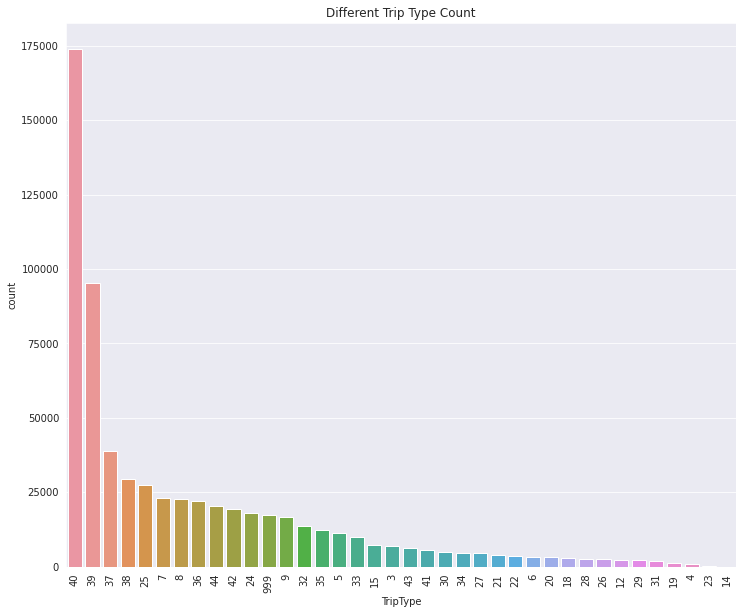

In [ ]:
#plotting trip type frequency
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'TripType', data = train, order = train['TripType'].value_counts().index).set(title='Different Trip Type Count')
plt.xticks(rotation=90)
sns.set(font_scale=2)

In [ ]:
train.DepartmentDescription.unique()
train.DepartmentDescription.value_counts()

GROCERY DRY GOODS         70402
DSD GROCERY               68332
PRODUCE                   51115
DAIRY                     43820
PERSONAL CARE             41969
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

To deduce whether there was a relationship between the department description and trip type, we plotted the frequency of the top 10 departments from which shoppers bought products from versus the trip type number. We found that trip types 40, 39, 37, 38, 7, and 8 seemed to be grocery trips of some sort, while trip types 36, 44, and 42 seemed to be household supply runs of some sort. Thus, it will be important to consider another factors like weekday vs. weekend, return vs. purchase, or the specific products purchased to differentiate trip types that seem to be overlapping like grocery/household trips.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text major ticklabel objects>)

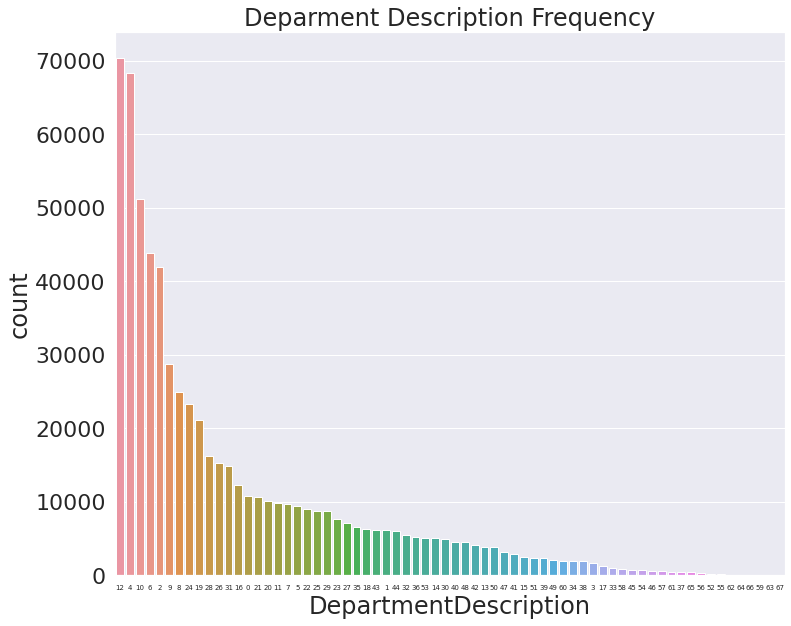

In [ ]:
#plotting department description frequency
## Creating a dictionary to convert department descriptions to ints
department_list=list(train['DepartmentDescription'].unique())
department_enumerate=list(enumerate(department_list))
department_dict={v:k for k,v in department_enumerate}
train.replace({'DepartmentDescription': department_dict},inplace=True)


## Plotting
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'DepartmentDescription', data = train, order = train['DepartmentDescription'].value_counts().index).set(title='Deparment Description Frequency')
plt.xticks(fontsize=7)

To start exploring these other factors, we analyzed the frequency of trips made on each weekday and created a pivot table to conduct a bivariate analysis between TripType and Weekday. This allowed us to visualize the probability that a certain TripType falls on a certain day. Interestingly, we found that TripType frequency seemed similar throughot the week, regardless of the weekday.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

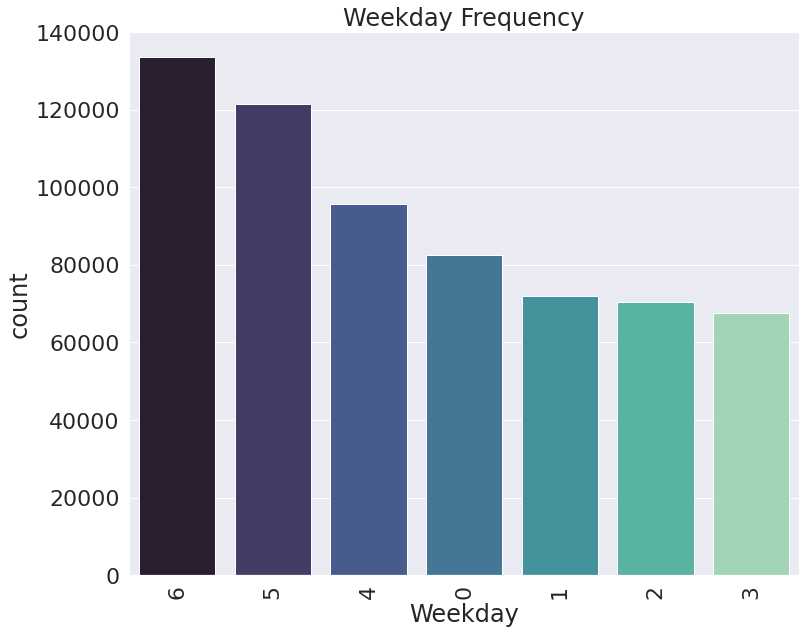

In [ ]:
#plotting weekday frequency
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'Weekday', data = train, palette = 'mako', order = train['Weekday'].value_counts().index).set(title='Weekday Frequency')
plt.xticks(rotation=90)

In [ ]:
## Creating a pivot table to do bivariate analysis between TripType and
## Weekday
Weekday_TripType = (
   train
    .pivot_table(index='TripType', columns='Weekday', values=None, aggfunc='size').fillna(0)
)


## calculating all the probabilities of getting a certain trip type,
## depending on the day of the week
for i in Weekday_TripType:
    Weekday_TripType[i] = Weekday_TripType[i] / Weekday_TripType[i].sum()
    
## Here I removed trip type 999 because it skewed our graph
Weekday_TripType = Weekday_TripType[:-1]
Weekday_TripType

Weekday,0,1,2,3,4,5,6
TripType,,,,,,,
3,0.010053,0.011956,0.012708,0.011268,0.014725,0.009610,0.006753
4,0.001344,0.001335,0.001674,0.001572,0.001569,0.001351,0.001132
5,0.017732,0.020408,0.022267,0.021677,0.018459,0.016190,0.011677
6,0.004070,0.004880,0.005460,0.005604,0.006850,0.007041,0.003313
7,0.039873,0.041247,0.045910,0.042389,0.033812,0.029407,0.030047
8,0.037753,0.041553,0.041116,0.042908,0.037295,0.029745,0.027648
9,0.024491,0.025037,0.028749,0.030024,0.028876,0.025998,0.022072
12,0.002507,0.002530,0.001603,0.001364,0.003096,0.005460,0.004130
14,0.000170,0.000000,0.000000,0.000000,0.000084,0.000107,0.000000


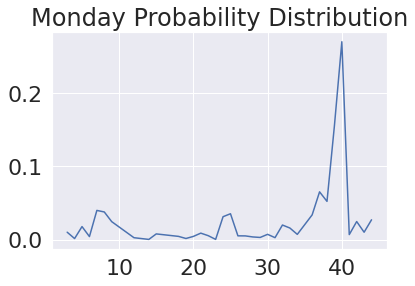

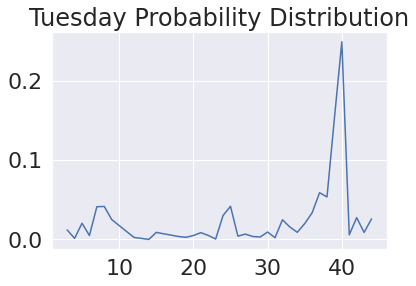

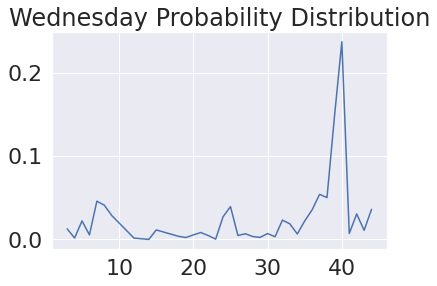

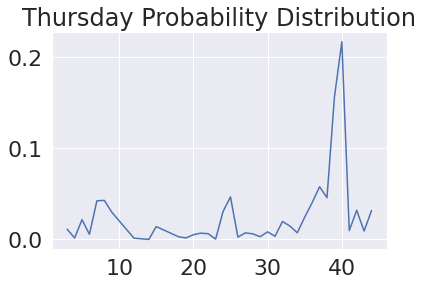

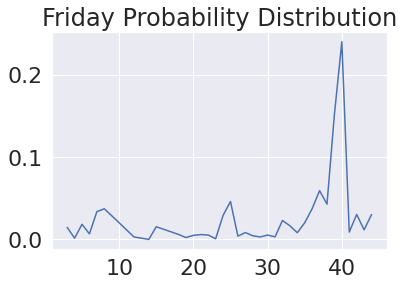

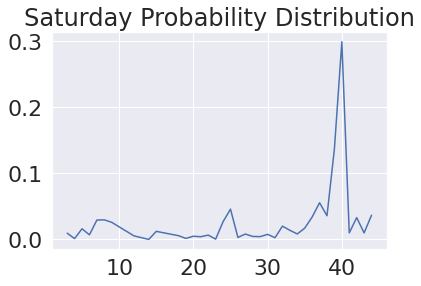

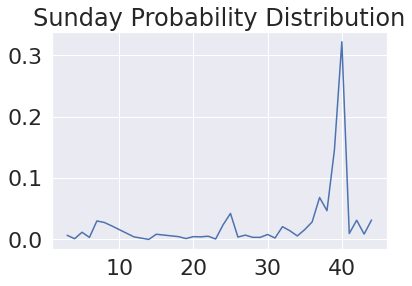

In [ ]:
## Here I used a for loop to plot the 
## Probabilies depending on the trip type
## for every day of the week. Here we can 
## see that trip types remain very similiar across
## the week days. This might be useful to consider when we decide how
## much weight to give weekdays in our model.
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday',}
for i in Weekday_TripType:
    plt.figure()
    plt.plot(Weekday_TripType.index, Weekday_TripType[i])
    plt.title(weekdays[i] + ' Probability Distribution')

##Feature Engineering

In [ ]:
#temp = pd.get_dummies(train, columns=['DepartmentDescription'])
#temp  = temp.dropna()
#temp.isnull().values.any()
#temp

In [ ]:
## Feature Engineering




## Create a new df to append a groupby series of the sum of items bought in each trip
items_bought_each_trip = pd.DataFrame()



## Groupby function asssigned to new col
items_bought_each_trip['item_sum'] = train.groupby(['VisitNumber'])['ScanCount'].sum()


## This merge creates a df that makes only one row for each trip containing its sum of items
merged = items_bought_each_trip.reset_index().merge(train[['TripType', 'VisitNumber', 'Weekday']].drop_duplicates(), on='VisitNumber', how = 'left')



## Another dataframe to OHE departments
new_df = train.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].sum().reset_index()

## OHE
temp = pd.get_dummies(new_df, columns=['DepartmentDescription',])

## THis bit of code I iterated throught the department desciption columns and made an
## aggregate function to make only one row per trip with each deparment description it 
## had showing as one
new_dict = {}
for i in temp:
    new_dict[i] = 'sum'
final = temp.groupby(temp['VisitNumber']).aggregate(new_dict)
final = final.iloc[: , 1:].reset_index()



## Merging the final df and merged df
temp = merged.merge(final, on='VisitNumber')


Turning weekday into cyclical variables with sine and cosine

In [ ]:
day_of_week = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
day = temp['Weekday'].map(day_of_week)
temp['sin_day'] = np.sin(2*np.pi*day/7)
temp['cos_day'] = np.cos(2*np.pi*day/7)
temp = temp.drop(['Weekday'], axis=1)
temp

,VisitNumber,item_sum,TripType,ScanCount,DepartmentDescription_0,DepartmentDescription_1,DepartmentDescription_2,DepartmentDescription_3,DepartmentDescription_4,DepartmentDescription_5,...,DepartmentDescription_60,DepartmentDescription_61,DepartmentDescription_62,DepartmentDescription_63,DepartmentDescription_64,DepartmentDescription_65,DepartmentDescription_66,DepartmentDescription_67,sin_day,cos_day
0,5,-1,999,-1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
1,7,2,30,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
2,8,27,26,27,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
3,9,3,8,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
4,10,3,8,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94242,191343,9,25,9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.781831,0.623490
94243,191344,5,22,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.781831,0.623490
94244,191345,17,39,17,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.781831,0.623490
94245,191346,17,39,17,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,-0.781831,0.623490


## Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
temp[['VisitNumber', 'item_sum', 'ScanCount']] = sc.fit_transform(temp[['VisitNumber', 'item_sum', 'ScanCount']])

## Final Test Set 
We will reserve 10% of our data for final validation. This will serve as our overall task performance benchmark.

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(temp, test_size = 0.1)
final_y_test = test_set['TripType']
final_X_test = test_set.drop(columns=["TripType"])

##Partitioning Train/Test Sets:
Initially, we decided that our train/test data splitting will be implemented using Kfold CV. But since we are working very large dataset (500k+ datapoints), we found we had insufficent compute resource to run too many iterations. Now, the data splitting will be done through a simple train-test partition with 70% of the datapoints in the training set and 30% in the validation set. 

In [ ]:
from sklearn.model_selection import train_test_split
#X = temp
y = train_set['TripType']
X = train_set.drop(columns=['TripType'])
#y = temp['TripType']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size = .70, shuffle=True)
print (y_test.unique().shape)
print(X_train.shape)


(38,)
(59375, 73)


# Proposed Solution

Our proposed solution is to use train and fit a model to the training data, evaluate its performance on the testing data, and then use cross validation to verify the accuracy of our results.

Given the nature of our problem, non-binary classification of trip type into 38 distinct categories, we have isolated some models we believe would be best suited for the task:

- Random Forest 
- Neural Networks

####Note On Model Selection:
The nature of our dataset naturally lends itself to certain models and leave other ones unviable. Because of the number of features we have and the large dataset, K-NN Classifiers would suffer. Logistic regression is another such classifer that we can rule out due to the non binary catagorization of our dataset. 

we also are constrained in our compute time and resource, this means that certain classifiers that have more complex training times must be evaluated more harshly.


# Evaluation Metrics

Given the context of our data and intended solution, we need a multiclass evaluation metric. Thus, we've chosen to evaluate the performance of our benchmark model and solution models by calculating the F1-score. The F1-score combines two metrics, precision and recall, using their harmonic mean to give one single number. Therefore, the F1-score would allow us to take both the number of false positives and false negatives of trip type classification into account. Further, the F1-score is a useful evaluation metric to compare against the accuracy scores of our proposed models, considering that we have an uneven class distribution. For this reason, we chose to calculate the F1-score with a weighted average to take into account the proportion of each trip type label in our dataset.



## Subsection 1: Random Forests

Our base random forest classifier model uses a maximum depth of 30 nodes and gives an average accuracy score of 0.63, precision score of 0.61, recall score of 0.63, and f1-score of 0.60. From here, we chose to hyperparameter tune many different paramters to evaluate how many trees we should consider in our model.

###Base Model 

Comparing base model with best hyperparameter model

Training and testing Base Model:

In [ ]:

#using random forest to classify data with dimensionality reduced to first feature
rfc = RandomForestClassifier(max_depth=30) #insert best parameters here
rfc.fit(X_train, y_train)

# Predicting the Test set results
pred = rfc.predict(X_test)
pred

##Results

Base model results:

In [ ]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.80      0.94      0.86       983
           4       0.15      0.04      0.07        90
           5       0.59      0.67      0.63       905
           6       0.73      0.59      0.65       344
           7       0.64      0.62      0.63      1568
           8       0.74      0.85      0.79      3281
           9       0.65      0.80      0.71      2536
          12       0.00      0.00      0.00        73
          14       0.00      0.00      0.00         1
          15       0.45      0.29      0.35       264
          18       0.39      0.25      0.30       148
          19       0.32      0.07      0.11       102
          20       0.49      0.37      0.42       171
          21       0.55      0.53      0.54       175
          22       0.35      0.09      0.15       252
          23       1.00      0.05      0.10        38
          24       0.56      0.42      0.48       708
          25       0.54    

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:", precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

Overall Accuracy: 0.5891067709356702
Overall F1_score: 0.5864447034271734
Overall Precision: 0.6146153880631122
Overall Recall: 0.5891067709356702


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)

print(confusion_matrix)

[[ 912    0    0 ...    0    0   17]
 [   0    2   78 ...    0    0    0]
 [   1   16  598 ...    0    2    1]
 ...
 [   0    0   13 ...    3    0    0]
 [   0    0    1 ...    1    8    0]
 [ 179    0   21 ...    0    0 1635]]


###Hyperparameter Tuning

using grid search to find the best parameters: this one takes no RAM but takes forever. Gridsearch is an exhuastive search for the best hyperparameters that runs the algorithm on every possible combination of parameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
rfc = RandomForestClassifier(max_depth = 30)
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Attempted to find best hyperparameters but due to extremely large run times, had to alter the parameter grid to fit a less computationally demanding grid search. 

In [ ]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [100,200,50]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg_params = {
"n_estimators": [100,200,50]

},

GSCV = GridSearchCV(rfc,random_grid,scoring="f1_weighted",verbose =3)
GSCV.fit(X_train,y_train)
print(GSCV.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.504 total time=   8.4s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.511 total time=   9.9s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.492 total time=  11.1s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.509 total time=   8.7s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.502 total time=   4.9s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.497 total time=  10.6s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, 

Using random search to find best parameters: this one is fast but not enough RAM. Randomly combines parameters with specified number of iterations and folds, can increase or deacrease but takes more RAM the larger the number of combinations is. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
 #Fit the random search model
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


exception calling callback for <Future at 0x7f8b9fc36f10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.7/dist-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/usr/local/lib/

TerminatedWorkerError: ignored

In [ ]:
rfc_random.best_params_

Training and testing best Hyperparameter model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#using random forest to classify data with dimensionality reduced to first feature
rfc = RandomForestClassifier(n_estimators = 1836, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 110, bootstrap = False)
rfc.fit(X_train, y_train)

# Predicting the Test set results
pred = rfc.predict(X_test)
pred

array([39,  8,  6, ..., 37,  8, 40])

Best Hyperparameter model results:

In [ ]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:", precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)

print(confusion_matrix)

Due to the high number of combination of parameters that can be passed into the model, the computational demand of these did not allow us to find the absolute best optimal hyperparameters for the algorithm, we had to narrow it down. Grid Search took extremely long to run, and if we used a good enough IDE then random search ran telling us that our best parameters were n_estimators at 1836, min_samples_split at10, min_samples_leaf at 2, max_features at sqrt, max_depth at 110, and bootstrap at false. When using this as our arguments for the model, the accuracy increases by 5%.

## Subsection 2: Neural Networks using SKLearn

Our second modeling approach includes exploring how to build a multi-layer perceptron model using SKLearn. Our base model gives an average accuracy score of 0.27, precision score of 0.53, recall score of 0.27, and f1-score of 0.26. To further optimize this model, we hyperparameter tuned the hidden layer sizes, activation, solver, alpha, and learning rate. To improve our base model, we feature scaled the numeric variables with Standard Scaler from our dataset, including visit number, item sum, and scan count, before implementing the same classifier.  This increased the model's average accuracy score to 0.62, the precision score to 0.61, the recall score to 0.62, and the f1-score to 0.61. 

###Base Model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
NN = MLPClassifier(hidden_layer_sizes=(), solver='adam', random_state=1, activation ="relu", learning_rate="constant", alpha=0.0001)

NN.fit(X_train,y_train)
pred = NN.predict(X_test)
pred 

array([39,  8,  8, ..., 38,  8, 38])

###Results

In [ ]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.75      0.32      0.45       989
           4       0.01      0.98      0.01        94
           5       0.88      0.03      0.06       906
           6       0.53      0.38      0.44       344
           7       0.72      0.02      0.04      1557
           8       0.83      0.10      0.18      3298
           9       0.76      0.08      0.14      2555
          12       0.04      0.03      0.03        72
          14       0.00      0.00      0.00         1
          15       0.23      0.30      0.26       266
          18       0.33      0.05      0.09       154
          19       0.32      0.08      0.13       101
          20       0.28      0.48      0.35       174
          21       0.24      0.47      0.32       169
          22       0.22      0.43      0.29       246
          23       0.16      0.38      0.23        37
          24       0.47      0.40      0.43       703
          25       0.73    

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:",precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

Overall Accuracy: 0.24647306165756278
Overall F1_score: 0.18441050280295837
Overall Precision: 0.47860255832947723
Overall Recall: 0.24647306165756278


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[ 168    0  745 ...    0    0    0]
 [   0    0   64 ...    0    0    0]
 [   0    0  800 ...    0    0    0]
 ...
 [   0    0   39 ...    0    2    0]
 [   0    0   12 ...    0   16    0]
 [  54    0 1038 ...    0    2  564]]


###Hyperparameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV

NN_params = {
    'hidden_layer_sizes': [(), (100,)],
    #'activation': ['tanh', 'relu'],
    #'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    
}

grid = GridSearchCV(NN, NN_params, scoring='f1_weighted', cv=3, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=constant;, score=0.134 total time=  16.8s
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=constant;, score=0.147 total time=  15.2s
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=constant;, score=0.264 total time=  23.4s
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=adaptive;, score=0.134 total time=  12.6s
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=adaptive;, score=0.147 total time=  15.5s
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=adaptive;, score=0.264 total time=  23.4s
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant;, score=0.045 total time= 1.0min
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant;, score=0.048 total time=  56.2s
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant;, score

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive;, score=0.110 total time=  45.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive;, score=0.040 total time=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 1/3] END alpha=0.05, hidden_layer_sizes=(), learning_rate=constant;, score=0.136 total time=   7.0s


## Results

In [ ]:
sc_NN = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', random_state=1, activation ="relu", learning_rate="constant", alpha=0.0001)

sc_NN.fit(sc_X_train,sc_y_train)
sc_pred = sc_NN.predict(sc_X_test)
sc_pred

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


array([ 5,  7,  6, ...,  8,  7, 40])

In [ ]:
print(classification_report(sc_y_test, sc_pred, zero_division = 0))

              precision    recall  f1-score   support

           3       0.79      0.91      0.84       986
           4       0.00      0.00      0.00        92
           5       0.56      0.80      0.66       899
           6       0.64      0.57      0.60       346
           7       0.64      0.68      0.66      1558
           8       0.70      0.85      0.77      3295
           9       0.64      0.77      0.70      2547
          12       0.25      0.14      0.18        74
          14       0.00      0.00      0.00         1
          15       0.47      0.32      0.38       260
          18       0.36      0.44      0.40       149
          19       0.30      0.18      0.23       100
          20       0.49      0.53      0.51       175
          21       0.61      0.50      0.55       172
          22       0.39      0.36      0.37       252
          23       0.38      0.26      0.31        38
          24       0.56      0.57      0.56       702
          25       0.59    

In [ ]:
print("Overall Accuracy:",accuracy_score(sc_y_test, sc_pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:",precision_score(sc_y_test, sc_pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(sc_y_test, sc_pred, average='weighted', zero_division=0))

Overall Accuracy: 0.6190120642904862
Overall F1_score: 0.18441050280295837
Overall Precision: 0.6132276286472151
Overall Recall: 0.6190120642904862


By updating the hidden layer sizes after using gridsearch, our F1 metric increases by 10% and the overall accuracy by almost 40%.

##Subsection 3: Neural Networks using Keras

To further explore neural network modeling, we used Keras. Using Keras allowed us to build our hidden layers within our code lines, while also implementing a categorical cross entropy loss function. 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(50, input_dim=72, activation='relu'))
	model.add(Dense(37, activation='relu'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

NN= KerasClassifier(build_fn=baseline_model, epochs =100,batch_size=5,verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(NN, sc_X_test, sc_y_test, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
4581/4581 - 9s - loss: nan - accuracy: 0.3835 - 9s/epoch - 2ms/step
Epoch 2/100
4581/4581 - 9s - loss: nan - accuracy: 0.4675 - 9s/epoch - 2ms/step
Epoch 3/100
4581/4581 - 9s - loss: nan - accuracy: 0.4770 - 9s/epoch - 2ms/step
Epoch 4/100
4581/4581 - 9s - loss: nan - accuracy: 0.4875 - 9s/epoch - 2ms/step
Epoch 5/100
4581/4581 - 10s - loss: nan - accuracy: 0.4853 - 10s/epoch - 2ms/step
Epoch 6/100
4581/4581 - 9s - loss: nan - accuracy: 0.4954 - 9s/epoch - 2ms/step
Epoch 7/100
4581/4581 - 9s - loss: nan - accuracy: 0.5000 - 9s/epoch - 2ms/step
Epoch 8/100
4581/4581 - 9s - loss: nan - accuracy: 0.5039 - 9s/epoch - 2ms/step
Epoch 9/100
4581/4581 - 9s - loss: nan - accuracy: 0.5021 - 9s/epoch - 2ms/step
Epoch 10/100
4581/4581 - 9s - loss: nan - accuracy: 0.5086 - 9s/epoch - 2ms/step
Epoch 11/100
4581/4581 - 9s - loss: nan - accuracy: 0.5102 - 9s/epoch - 2ms/step
Epoch 12/100
4581/4581 - 9s - lo

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local/

## Results

This model gives an average accuracy score of ___, precision score of ___, recall score of ___, and f1_score of ____.

##Subsection 4: Model Comparison

To compare the efficacy of our models in predicting which trip type class each of our data points belonged to, we used the 10% reserve of our data—our final test set—to validate our results. Comparing the f1-score and accuracy scores of our models, we found that Random Forests performed Best.

### Comparing models with cross validation

In [ ]:
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

# Import required libraries for machine learning classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


# Define dictionary with performance metrics we want to use
score = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

# Initializing the machine learning classifiers
rfc_model = RandomForestClassifier()
nn_model = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', random_state=1, activation ="relu", learning_rate="constant", alpha=0.0001)


def model_evaluation(X, y, kfolds):
    
    
    # Performing cross-validation to each machine learning classifier

  
    rfc = cross_validate(rfc_model, X, y, cv=kfolds, scoring=score)
    nn = cross_validate(nn_model, X, y, cv=kfolds, scoring=score)

    # Create a data frame with the models performance metrics scores
    models_scores_frame = pd.DataFrame({
                                      'Random Forests':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Neural Networks':[nn['test_accuracy'].mean(),
                                                              nn['test_precision'].mean(),
                                                              nn['test_recall'].mean(),
                                                              nn['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
      # Add 'Best Score' column
    models_scores_frame['Highest Score'] = models_scores_frame.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_frame)
  
# Run models_evaluation function
model_evaluation(X_train, y_train, 5)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", li

,Random Forests,Neural Networks,Highest Score
Accuracy,NaN,NaN,NaN
Precision,NaN,NaN,NaN
Recall,NaN,NaN,NaN
F1 Score,NaN,NaN,NaN


# Discussion

In attempts to balance the imbalanced data set, we tried using Random Oversampler from Imablanced Learn. However upon balancing the data set, our model metrics decreased, thus we kept the data set imbalanced. Problems we encountered were extremely long runtimes due to the large data set. This did not allow us to see the maximal results in hyperparameter search, as well as unideal metric scores in both Neural Networks and Random Forests. These both are Naive Bayes algorithms which we thought would be optimal for our data set. We also attempted a one vs one multiclass classification strategy using SVC but decided not to include it due to extremely low metric scores and even longer runtimes. We were expecting to see better metric scores for both our models, with more time we would perform more data preprocessing, a more in depth feature selection, and maybe with more computational power run more exhaustive searches to find better hyperparameters. Overall Random Forests with the hyperparameters found with Random Search output the best metric score.
 

# Limitations

Constrained Model Training:
Given the compute resource contraint, we were only able to train all of our models with a class balanced random sample (75k samples) of the larger training dataset. This was done to allow for faster training times, which ultimately allowed for more granular hyperparameter tuning. We then trained/tested the best model on the entire dataset. Thus, the size of our sample and compute resource were significant limitations in this project.

Knowledge of Neural Networks:
We chose to explore modeling with neural networks as it was a common interest among our entire group. However, as we only have introductory knowledge of neural networks, we didn't have sufficient understanding to optimize our model to the best it could be. For example, although we invested effort into researching hidden layer architecture, we ultimately had to hand-design the number of layers/nodes in our model by making our best educated guess.

# Ethics & Privacy

Our data does not involve anyones data or identity so it would be difficult to find a breach of ethics or privacy. One ethical dilemma that might arise is the increasing amount of data available to big corporations and how they’re using this big data to fine tune their products to keep the average person consuming even more. It would be prudent to question whether it is completely ethical for corporations to treat everyone as a number to maximize their profits.




# Team Expectations 

Put things here that cement how you will interact/communicate as a team, how you will handle conflict and difficulty, how you will handle making decisions and setting goals/schedule, how much work you expect from each other, how you will handle deadlines, etc...

- Arrange bi-weekly meetings that works with everyones schedule
- Use a discord server to communicate with one another
- Make use of project managment software to track progress
- Be mindful of git -pull-push-overwrites such that no code is overwritten or needlessly repeated

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/24  |  3:30 PM |  Edit, finalize, and submit proposal; Search for datasets  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part | 
| 5/16  |  9 PM |  Delegate tasks for first checkpoint and discuss wrangling, cleaning, and EDA plan | Import and wrangle data, do some EDA | 
| 5/19  | 9 PM  | Edit and finalize data cleaning and wrangling/EDA  | Review/discuss EDA, debug, and submit checkpoint   |
| 5/23  | 7 PM  | Finalize project/conclusion/discussion | Discuss conclusion   |
| 6/8  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="first"></a>1.[^](#firstnote): Oliver Kramer. K Nearest Neighbors. https://link.springer.com/chapter/10.1007/978-3-642-38652-7_2<br> 
<a name="second"></a>2.[^](#secondnote): Srivastava et al. (1999) Parallel Forumlations of Decision Tree Classfication Algorithms. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.41.7475&rep=rep1&type=pdf<br>
<a name="third"></a>3.[^](#thirdnote): M. Pal (2005).Random forest classifier for remote sensing classification. https://www.tandfonline.com/doi/pdf/10.1080/01431160412331269698?casa_token=e78vG4sBDLcAAAAA:p9nt0mSjEMuazyQsDjprmwIIFt9aNRk9EtF7eKRyNozF6FsAskuvXKrMxnnftOK0xFjlUm5MX9g.<br>
<a name="fourth"></a>4.[^](#fourthnote): Stephan Dreiseitl and Lucila Ohno_Machado. (2002). Logistic regression and artificial neural network classification models: a methodology review. https://www.sciencedirect.com/science/article/pii/S1532046403000340.<br>
<a name="fifth"></a>5.[^](#fifthnote): Cui et al. (2018). Deep Embedding Logistic Regression. https://ieeexplore.ieee.org/document/8588790

